In [1]:
import numpy as np 
import pyxu.experimental.xray as pxr
import pyxu.opt.stop as pxst
import matplotlib.pyplot as plt
import xrt_splines
import pat_xrt
import matplotlib
import cupy as cp
from cupyx.profiler import benchmark
from skimage.transform import iradon
from scipy.signal import convolve2d as spconv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from scipy.signal import fftconvolve
from skimage.transform import resize
import xdesign as xd

cp.cuda.Device(0).use()

<CUDA Device 0>

In [29]:
def set_operators_fan_beam(N_side, N_angle, N_offset, pitch_op, arg_shape, sod, sdd):
    # Let's build the necessary components to instantiate the operator . ========================
    angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)
    origin  = (0., 0.)

    ray_t = np.zeros((N_angle * N_offset, 2))  # Ray origin
    ray_n = np.zeros((N_angle * N_offset, 2))  # Ray direction

    # Compute rays for each angle
    for i in range(N_angle):
        theta = angles[i]
        
        # Compute source position (on a circular path)
        source = np.array([sod * np.cos(theta), sod * np.sin(theta)])

        # Define detector arc (equally spaced points)
        detector_offsets = 1.5* np.linspace(-N_side/2, N_side/2, N_offset)
        
        detector_x = detector_offsets * np.cos(theta + np.pi / 2)
        detector_y = detector_offsets * np.sin(theta + np.pi / 2)
        
        detectors = np.stack([detector_x, detector_y], axis=1)  # Shape: (N_detectors, 2)

        # Compute ray directions
        start_idx = i * N_offset
        ray_t[start_idx:start_idx + N_offset, :] = source + np.array([N_side/2, N_side/2])
        ray_n[start_idx:start_idx + N_offset, :] = detectors - sdd*np.array([np.cos(theta), np.sin(theta)])  # Shape: (N_detectors, 2)
        
        # Normalize directions
        norm_factor = np.linalg.norm(ray_n[start_idx:start_idx + N_offset], axis=1, keepdims=True)
        ray_n[start_idx:start_idx + N_offset] /= norm_factor


    # Convert to CuPy for GPU acceleration
    t_spec = cp.array(ray_t)
    n_spec = cp.array(ray_n)

    op_splines_1 = xrt_splines.RayXRT(
        deg=1,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_splines_2 = xrt_splines.RayXRT(
        deg=2,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_pixels = pxr.XRayTransform.init(
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )

    return op_pixels, op_splines_1, op_splines_2



def create_phantom(N_side, type):
    if type=='gaussian':
        xx = np.linspace(-N_side//2,N_side//2, num=N_side)
        yy = xx
        X, Y = np.meshgrid(xx,yy)
        r = 700
        mask = np.sqrt(X**2 + Y**2) < r
        phantom = np.exp(-((X-517)**2 + (Y+429)**2)/400000) + 0.5*np.exp(-((X+673)**2 + (Y-687)**2)/400000)

    if type=='sharp':
        seed = 0
        # Generate phantom with xdesign
        np.random.seed(seed)
        p1 = xd.Foam(size_range=[0.1, 0.01], gap=0.025, porosity=0.5)
        phantom = xd.discrete_phantom(p1, N_side-400-370) * 10
        phantom = np.pad(phantom, ((370, 0), (370, 0)))
        phantom = np.abs(np.pad(phantom, 200))
    return cp.array(phantom)

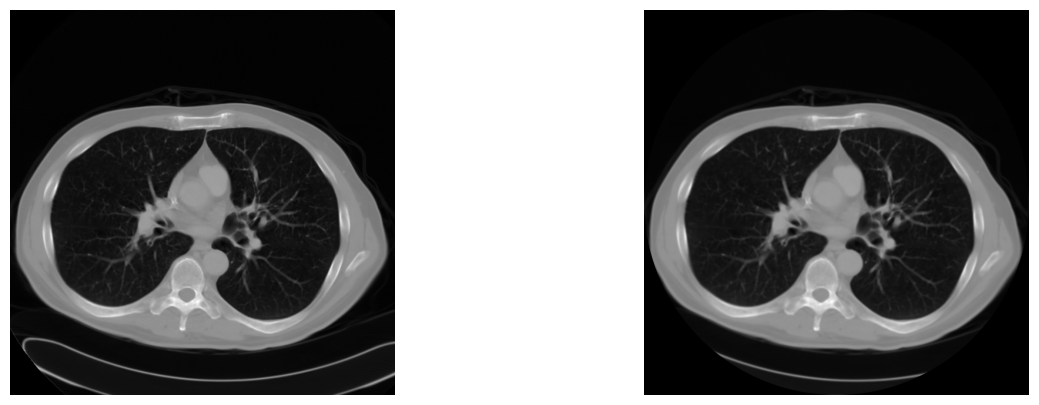

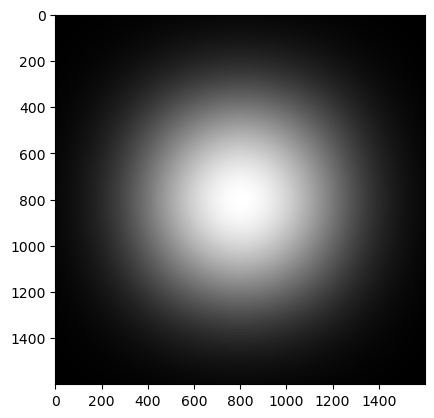

In [30]:
import astra 

N_side = 3000
N_basis = 1600
XX, YY = np.meshgrid(np.linspace(-1.5, 1.5, N_basis), np.linspace(-1.5, 1.5, N_basis))
YY = np.flip(YY, axis=0)
pixelsize = 3/N_basis

spline_basis1 = np.zeros((N_basis, N_basis))
spline_basis1 = np.where(np.abs(YY)<pixelsize, 1, 0)
spline_basis1 = np.where(XX<1/2, spline_basis1, 0)
spline_basis1 = np.where(XX>-1/2, spline_basis1, 0)

spline_basis2 = np.zeros((N_basis, N_basis))
spline_basis2 = np.where(np.abs(XX)<pixelsize, 1, 0)
spline_basis2 = np.where(YY<1/2, spline_basis2, 0)
spline_basis2 = np.where(YY>-1/2, spline_basis2, 0)

spline_basis3 = np.zeros((N_basis, N_basis))
spline_basis3 = np.where(np.abs(XX-YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis3 = np.where(XX < 1/2, spline_basis3, 0)
spline_basis3 = np.where((XX) > -1/2, spline_basis3, 0)

spline_basis4 = np.zeros((N_basis, N_basis))
spline_basis4 = np.where(np.abs(XX+YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis4 = np.where(XX < 1/2, spline_basis4, 0)
spline_basis4 = np.where((XX) > -1/2, spline_basis4, 0)

spline_basis_0 = fftconvolve(spline_basis1, spline_basis2, mode='same')
spline_basis_1 = fftconvolve(spline_basis_0, spline_basis3, mode='same')
spline_basis_2 = fftconvolve(spline_basis_1, spline_basis4, mode='same')
final_size = N_side
#spline_basis_1 = np.flip(spline_basis_1, axis=0)

#random_phantom = np.random.randn(50, 50)
from skimage import io

image_path = "true.tiff"
# Open the TIFF image
random_phantom = io.imread(image_path)[12:512, :500]
oversampling = 500
factor = final_size//oversampling

spline_basis_3 = fftconvolve(spline_basis_0, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same')

spline_basis = resize(spline_basis_3, (3*factor, 3*factor), anti_aliasing=False)
full_im_spline = np.zeros((final_size, final_size))
for i in range(oversampling):
    for j in range(oversampling):
        full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = random_phantom[i, j]

phantom = fftconvolve(full_im_spline, spline_basis, mode='same')
#circle mask with zeros outside
XX, YY = np.meshgrid(np.linspace(-1, 1, final_size), np.linspace(-1, 1, final_size))
mask = np.sqrt(XX**2 + YY**2) < 1
phantom = (phantom - np.min(phantom))/(np.max(phantom) - np.min(phantom))
phantom = phantom*mask
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(random_phantom, cmap='gray')
ax[1].imshow(phantom, cmap='gray')
for a in ax:
    a.axis('off')
plt.show()
phantom = cp.array(phantom)/np.max(phantom)
plt.figure()
plt.imshow(spline_basis_3, cmap='gray')
plt.show()

#phantom = create_phantom(N_side, "gaussian")
phantom /= cp.max(phantom)

def run_xp(N_angle, N_offset, oversampling, phantom):
    
    arg_shape = phantom.shape

    pitch_op = (1.,1.) 

    angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)
    vol_geom = astra.create_vol_geom(phantom.shape[0], phantom.shape[1])
    det_spacing = 1.5*N_side/N_offset
    proj_geom = astra.create_proj_geom('fanflat', det_spacing, N_offset, angles, 6000, 1500)#source_origin, origin_det
    proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
    sinogram_id, y_data_astra = astra.create_sino(np.array(phantom.get()), proj_id)
    y_data = cp.array(y_data_astra).reshape(-1) #+ 1*cp.random.randn(N_angle*N_offset)

    #y_data_astra = op_splines_2.apply(phantom.reshape(-1)).reshape((N_angle, N_offset)).get()
    
    ####### rec astra ########
    
    proj_geom = astra.create_proj_geom('fanflat', 1.5/(N_offset/oversampling), N_offset, angles, 6000*oversampling/N_side, 1500*oversampling/N_side)#source_origin, origin_det
    vol_geom  = astra.create_vol_geom(oversampling, oversampling)

    proj_id = astra.create_projector('cuda', proj_geom, vol_geom)
    sino_id   = astra.data2d.create('-sino', proj_geom, y_data_astra)
    rec_id    = astra.data2d.create('-vol', vol_geom)

    cfg       = astra.astra_dict('CGLS_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId']      = sino_id
    cfg['ProjectorId']          = proj_id

    alg_id    = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id, 30)
    rec_astra              = astra.data2d.get(rec_id)
    ############################


    stop_crit = pxst.MaxIter(30)
    
    pitch_op = (phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
    arg_shape = (oversampling, oversampling)
    op_pixels, op_splines_1, op_splines_2 = set_operators_fan_beam(N_side, N_angle, N_offset, pitch_op, arg_shape, 6000, 7500) #sod sdd

    recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

    factor = final_size//oversampling


    rec_pix = recon_pixels.get()
    spline_basis = resize(spline_basis_0, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_pix = np.zeros((final_size, final_size))

    for i in range(oversampling):
        for j in range(oversampling):
            full_im_pix[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_pix[i, j]

    full_im_pix = fftconvolve(full_im_pix, spline_basis, mode='same')
    
    #for astra, use pixels also
    full_im_astra = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_astra[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_astra[i, j]

    full_im_astra = fftconvolve(full_im_astra, spline_basis, mode='same')

    rec_spline = recon_box_1.get()
    spline_basis = resize(spline_basis_1, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_spline = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_spline[i, j]

    full_im_spline1 = fftconvolve(full_im_spline, spline_basis, mode='same')

    rec_spline = recon_box_2.get()
    spline_basis = resize(spline_basis_2, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_spline = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_spline[i, j]

    full_im_spline2 = fftconvolve(full_im_spline, spline_basis, mode='same')

    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax[0].imshow(full_im_pix, cmap='gray')
    ax[1].imshow(full_im_spline1, cmap='gray')
    ax[2].imshow(full_im_spline2, cmap='gray')
    ax[3].imshow(full_im_astra, cmap='gray')
    
    for a in ax:
        a.axis('off')
    #plt.savefig('upsampled.eps', format='eps')

    loss1 = psnr(phantom.get()/np.max(phantom.get()), full_im_pix/np.max(full_im_pix))
    loss2 = psnr(phantom.get()/np.max(phantom.get()), full_im_spline1/np.max(full_im_spline1))
    loss3 = psnr(phantom.get()/np.max(phantom.get()), full_im_spline2/np.max(full_im_spline2))
    loss4 = psnr(phantom.get()/np.max(phantom.get()), full_im_astra/np.max(full_im_astra))

    ssim1 = ssim(phantom.get()/np.max(phantom.get()), full_im_pix/np.max(full_im_pix), data_range=2)
    ssim2 = ssim(phantom.get()/np.max(phantom.get()), full_im_spline1/np.max(full_im_spline1), data_range=2)
    ssim3 = ssim(phantom.get()/np.max(phantom.get()), full_im_spline2/np.max(full_im_spline2), data_range=2)
    ssim4 = ssim(phantom.get()/np.max(phantom.get()), full_im_astra/np.max(full_im_astra), data_range=2)
    
    plt.show()
    
    return loss1, loss2, loss3, loss4, full_im_pix, full_im_spline1, full_im_spline2, full_im_astra, ssim1, ssim2, ssim3, ssim4


Oversampling :  500


/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
INFO:/tmp/pyxu_2p_jfydn:[2025-03-17 18:24:53.501690] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_2p_jfydn:[2025-03-17 18:24:53.521769] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_2p_jfydn:[2025-03-17 18:24:53.533797] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_2p_jfydn:[2025-03-17 18:24:53.545795] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_2p_jfydn:[2025-03-17 18:24:53.557693] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_2p_jfydn:[2025-03-17 18:24:53.569718] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_2p_jfydn:[2025-03-17 18:24:53.581438] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_2p_jfydn:[2025-03-17 18:24:53.593272] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_2p_jfydn:[2025-03-17 18:24:53

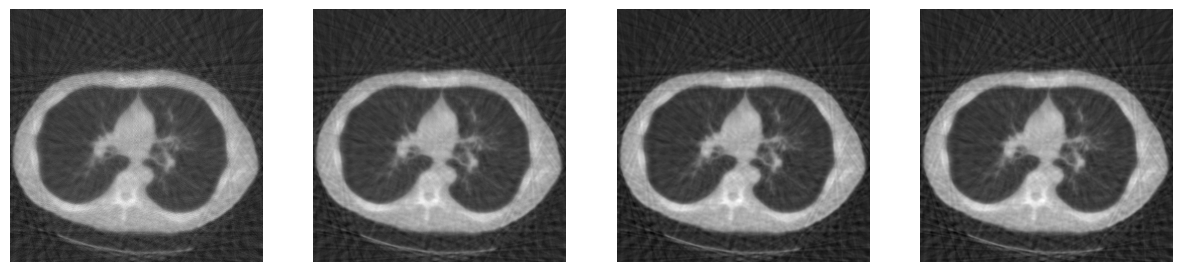

Losses :  24.066667423050564 26.28697927868319 26.09499486336008 25.828900149892643
SSIM :  0.593338728871951 0.7486666785809419 0.7672733052962126 0.7490269879360762
Oversampling :  500


INFO:/tmp/pyxu_ehplq922:[2025-03-17 18:25:09.303892] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_ehplq922:[2025-03-17 18:25:09.325482] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_ehplq922:[2025-03-17 18:25:09.337457] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_ehplq922:[2025-03-17 18:25:09.349873] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_ehplq922:[2025-03-17 18:25:09.362399] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_ehplq922:[2025-03-17 18:25:09.374666] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_ehplq922:[2025-03-17 18:25:09.387214] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_ehplq922:[2025-03-17 18:25:09.399193] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_ehplq922:[2025-03-17 18:25:09.411503] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_ehplq922:[2025-03-17 18:25:09.423595] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_ehplq922:[2025-03-17 18:25:09.435873] Iteration 10
	iteration: 1

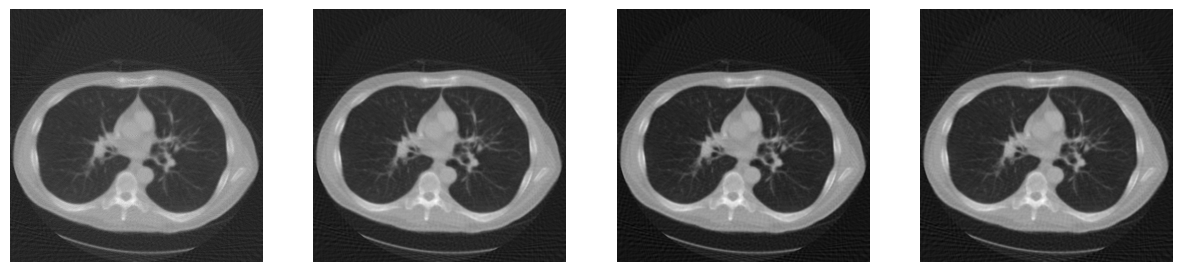

Losses :  28.754201628692783 32.356899576423395 33.10849278960261 32.702223661061296
SSIM :  0.7560938098775821 0.8723765033252026 0.8893328362870533 0.8617840337757243
Oversampling :  500


INFO:/tmp/pyxu_zti95xdg:[2025-03-17 18:25:27.446568] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_zti95xdg:[2025-03-17 18:25:27.469552] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_zti95xdg:[2025-03-17 18:25:27.482382] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_zti95xdg:[2025-03-17 18:25:27.495420] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_zti95xdg:[2025-03-17 18:25:27.508790] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_zti95xdg:[2025-03-17 18:25:27.521715] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_zti95xdg:[2025-03-17 18:25:27.534368] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_zti95xdg:[2025-03-17 18:25:27.547102] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_zti95xdg:[2025-03-17 18:25:27.560050] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_zti95xdg:[2025-03-17 18:25:27.572849] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_zti95xdg:[2025-03-17 18:25:27.585876] Iteration 10
	iteration: 1

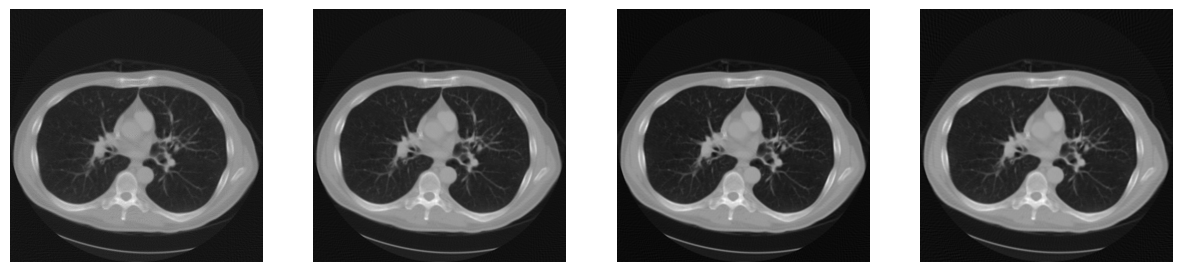

Losses :  31.4260859970052 36.17210994488234 37.03477254949853 36.76421777628591
SSIM :  0.8642486513047032 0.9494800166638205 0.9610289496757995 0.9362850895199902
Oversampling :  500


INFO:/tmp/pyxu_ww1ax8j1:[2025-03-17 18:25:50.580986] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_ww1ax8j1:[2025-03-17 18:25:50.604219] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_ww1ax8j1:[2025-03-17 18:25:50.618897] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_ww1ax8j1:[2025-03-17 18:25:50.633426] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_ww1ax8j1:[2025-03-17 18:25:50.648043] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_ww1ax8j1:[2025-03-17 18:25:50.662489] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_ww1ax8j1:[2025-03-17 18:25:50.677058] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_ww1ax8j1:[2025-03-17 18:25:50.691419] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_ww1ax8j1:[2025-03-17 18:25:50.705935] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_ww1ax8j1:[2025-03-17 18:25:50.720467] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_ww1ax8j1:[2025-03-17 18:25:50.735098] Iteration 10
	iteration: 1

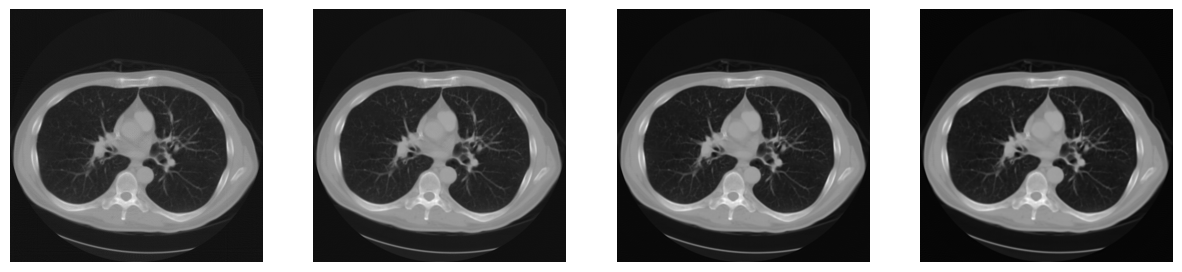

Losses :  33.52965470763103 37.543706042713595 38.368149156482296 38.75301306977671
SSIM :  0.9287905611996639 0.9813962146765914 0.9885564657609358 0.9785234708301781
Oversampling :  500


INFO:/tmp/pyxu_tnt0fqyp:[2025-03-17 18:26:23.798074] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_tnt0fqyp:[2025-03-17 18:26:23.828962] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_tnt0fqyp:[2025-03-17 18:26:23.846642] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_tnt0fqyp:[2025-03-17 18:26:23.864275] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_tnt0fqyp:[2025-03-17 18:26:23.881926] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_tnt0fqyp:[2025-03-17 18:26:23.899769] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_tnt0fqyp:[2025-03-17 18:26:23.917374] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_tnt0fqyp:[2025-03-17 18:26:23.934927] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_tnt0fqyp:[2025-03-17 18:26:23.952413] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_tnt0fqyp:[2025-03-17 18:26:23.969826] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_tnt0fqyp:[2025-03-17 18:26:23.987686] Iteration 10
	iteration: 1

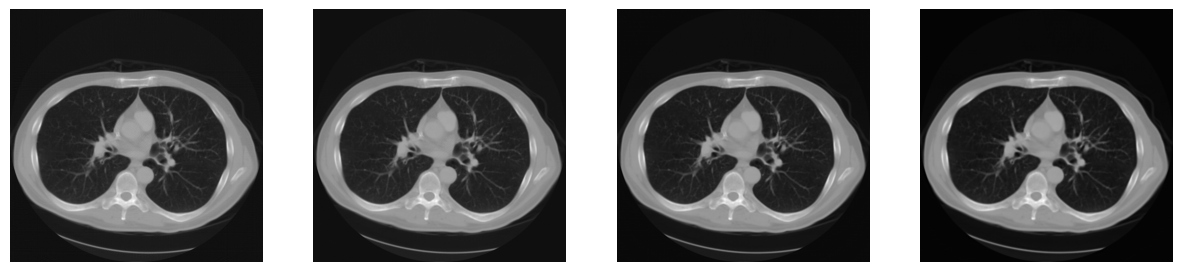

Losses :  35.04984049549266 38.159181345182674 38.52739846812847 39.07421423118188
SSIM :  0.9540669190966833 0.9876986474945173 0.9919888775969641 0.9840802751552918
Oversampling :  500


INFO:/tmp/pyxu_4b204_xa:[2025-03-17 18:27:16.660866] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_4b204_xa:[2025-03-17 18:27:16.692688] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_4b204_xa:[2025-03-17 18:27:16.714801] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_4b204_xa:[2025-03-17 18:27:16.737046] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_4b204_xa:[2025-03-17 18:27:16.759205] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_4b204_xa:[2025-03-17 18:27:16.781413] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_4b204_xa:[2025-03-17 18:27:16.804333] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_4b204_xa:[2025-03-17 18:27:16.826915] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_4b204_xa:[2025-03-17 18:27:16.849358] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_4b204_xa:[2025-03-17 18:27:16.871213] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_4b204_xa:[2025-03-17 18:27:16.893086] Iteration 10
	iteration: 1

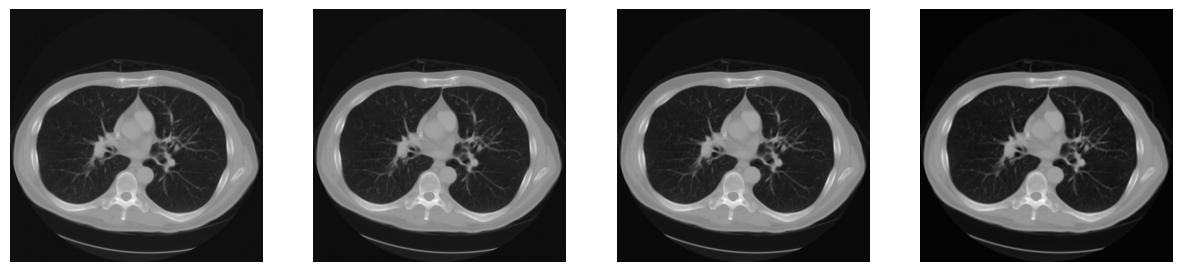

Losses :  35.654610478780924 38.3322500839261 38.50141505413198 39.09701063760045
SSIM :  0.9700940198627837 0.9906143337253344 0.9922172979830859 0.9842862697175376


In [31]:
oversamplings =[500]

losses1 = np.zeros(6)
losses2 = np.zeros(6)
losses3 = np.zeros(6)
losses4 = np.zeros(6)

ssims1 = np.zeros(6)
ssims2 = np.zeros(6)
ssims3 = np.zeros(6)
ssims4 = np.zeros(6)

losses1_temp = []
losses2_temp = []
losses3_temp = []
losses4_temp = [] 

images_pix = []
images_spline1 = []
images_spline2 = []
images_astra = []

c = 0

for oversampling in oversamplings:
    c = 0
    
    for k in [0.1, 0.25, 0.5, 1, 2, 4]:
        print('Oversampling : ', oversampling)
        loss1, loss2, loss3, loss4, full_im_pix, full_im_spline1, full_im_spline2, full_im_astra, ssim1, ssim2, ssim3, ssim4 = run_xp(int(oversampling*k), int(1*oversampling), oversampling, phantom)
        losses1_temp.append(loss1)
        losses2_temp.append(loss2)
        losses3_temp.append(loss3)
        losses4_temp.append(loss4)

        c += 1

        images_pix.append(full_im_pix)
        images_spline1.append(full_im_spline1)
        images_spline2.append(full_im_spline2)
        images_astra.append(full_im_astra)
        
        print('Losses : ', loss1, loss2, loss3, loss4)
        print('SSIM : ', ssim1, ssim2, ssim3, ssim4)

    '''losses1_temp /= np.max(losses1_temp)
    losses2_temp /= np.max(losses2_temp)
    losses3_temp /= np.max(losses3_temp)
    losses4_temp /= np.max(losses4_temp)'''

    losses1 += losses1_temp
    losses2 += losses2_temp
    losses3 += losses3_temp
    losses4 += losses4_temp
    losses1_temp = []
    losses2_temp = []
    losses3_temp = []
    losses4_temp = []

In [ ]:
#save everything
factors = [0.25, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
np.save('factors.npy', factors)
np.save('losses1_fac.npy', losses1)
np.save('losses2_fac.npy', losses2)
np.save('losses3_fac.npy', losses3)
np.save('losses4_fac.npy', losses4)
np.save('ssims1_fac.npy', ssims1)
np.save('ssims2_fac.npy', ssims2)
np.save('ssims3_fac.npy', ssims3)
np.save('ssims4_fac.npy', ssims4)
'''
np.save('images_pix.npy', images_pix)
np.save('images_spline1.npy', images_spline1)
np.save('images_spline2.npy', images_spline2)
np.save('images_astra.npy', images_astra)'''

[24.06666742 28.75420163 31.426086   33.52965471 35.0498405  35.65461048]


"\nnp.save('images_pix.npy', images_pix)\nnp.save('images_spline1.npy', images_spline1)\nnp.save('images_spline2.npy', images_spline2)\nnp.save('images_astra.npy', images_astra)"

In [ ]:
#load everything
oversamplings = np.load('oversamplings.npy')
losses1 = np.load('losses1.npy')
losses2 = np.load('losses2.npy')
losses3 = np.load('losses3.npy')
losses4 = np.load('losses4.npy')
ssims1 = np.load('ssims1.npy')
ssims2 = np.load('ssims2.npy')
ssims3 = np.load('ssims3.npy')
ssims4 = np.load('ssims4.npy')
images_pix = np.load('images_pix.npy')
images_spline1 = np.load('images_spline1.npy')
images_spline2 = np.load('images_spline2.npy')
images_astra = np.load('images_astra.npy')

ValueError: x and y must have same first dimension, but have shapes (6,) and (13,)

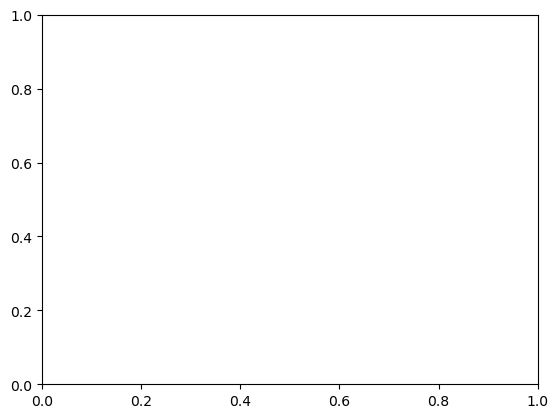

In [25]:

plt.figure('Losses')
oversamplings = [0.1, 0.25, 0.5, 1, 2, 4]
plt.plot(oversamplings, losses1, label='Pixels psnr')
plt.plot(oversamplings, losses2, label='Box-splines 1 psnr')
plt.plot(oversamplings, losses3, label='Box-splines 2 psnr')
#plt.plot(oversamplings, losses4, label='Astra psnr')

plt.scatter(oversamplings, losses1)
plt.scatter(oversamplings, losses2)
plt.scatter(oversamplings, losses3)
#plt.scatter(oversamplings, losses4)
plt.show()

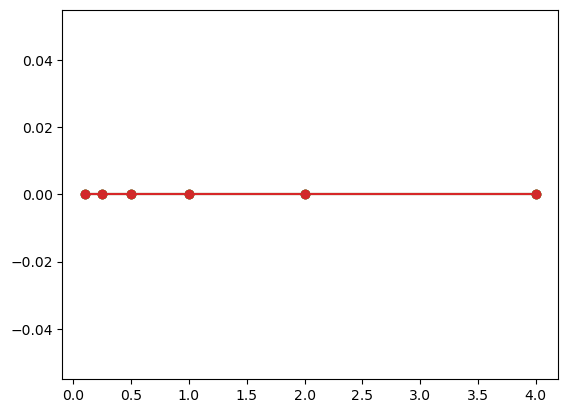

In [23]:
plt.figure('SSIM')
plt.plot(oversamplings, ssims1, label='Pixels ssim')
plt.plot(oversamplings, ssims2, label='Box-splines 1 ssim')
plt.plot(oversamplings, ssims3, label='Box-splines 2 ssim')
plt.plot(oversamplings, ssims4, label='Astra ssim')

plt.scatter(oversamplings, ssims1)
plt.scatter(oversamplings, ssims2)
plt.scatter(oversamplings, ssims3)
plt.scatter(oversamplings, ssims4)

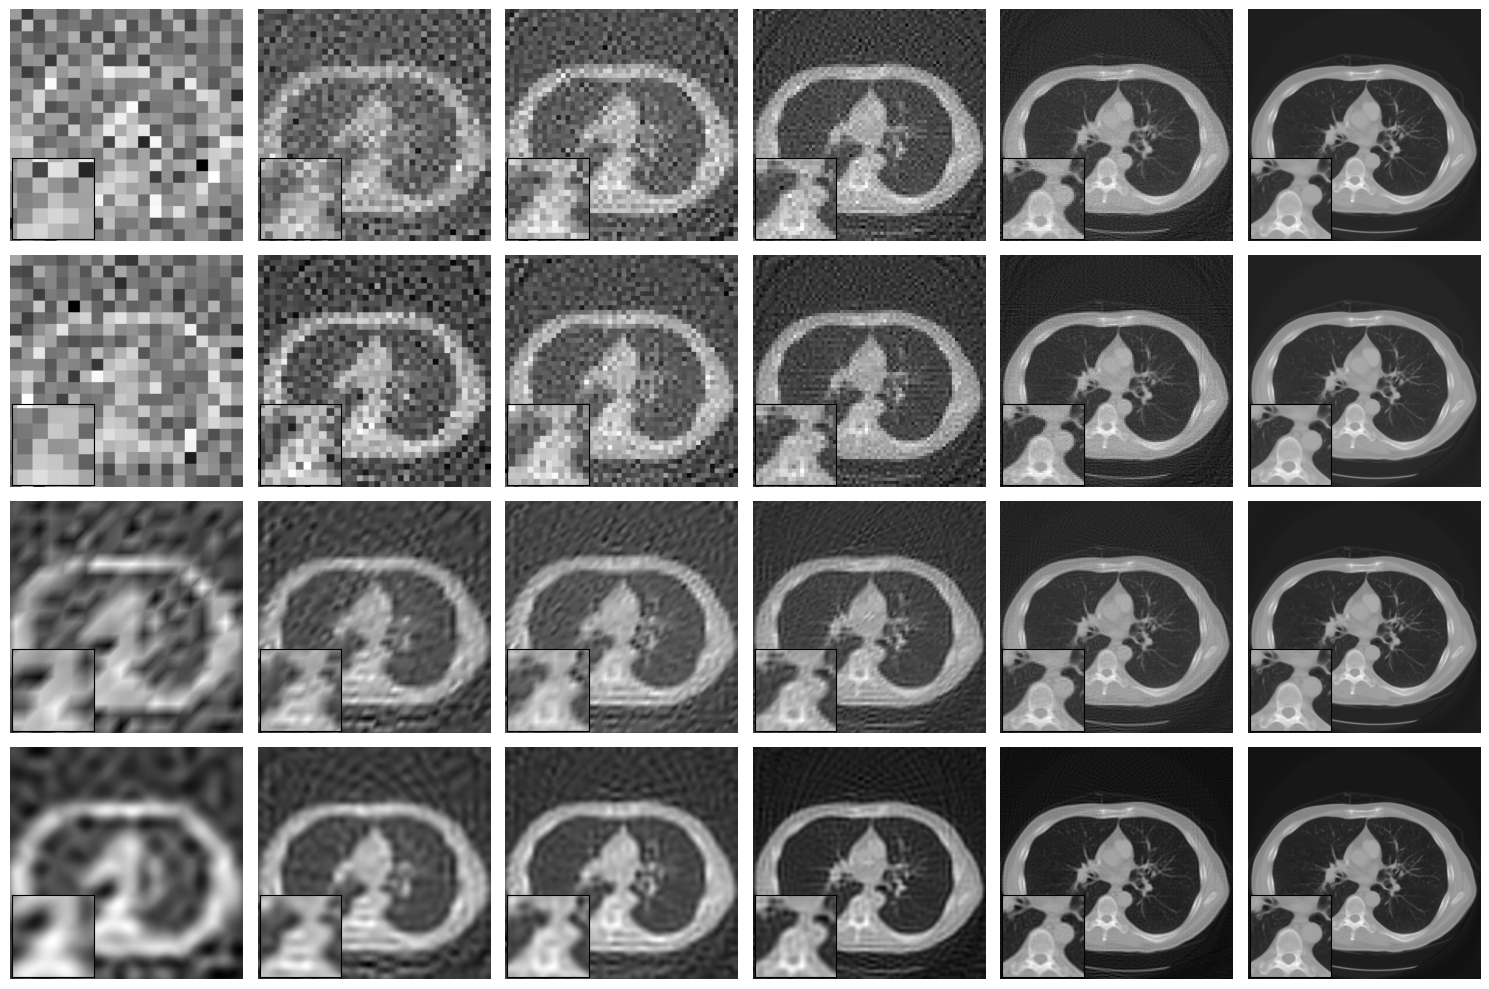

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create figure and subplots
fig, ax = plt.subplots(4, 6, figsize=(15, 10))
k = 0

# Define the zoom-in region (adjust these values based on your images)
x1, x2, y1, y2 = 1000, 1800, 600, 1400  # Example: Region to zoom into

for i in range(len(oversamplings)):
    if i in [0, 1, 2, 3, 6, 12]:  # Select specific oversampling values
        images = [images_pix[i], images_astra[i], images_spline1[i], images_spline2[i]]
        
        for row in range(4):
            # Display main image
            ax[row, k].imshow(images[row], cmap='gray')
            ax[row, k].axis('off')

            # Add inset for zoomed-in view
            axins = ax[row, k].inset_axes([0.01, 0.01, 0.35, 0.35])  # (x, y, width, height)
            #remove ticks
            axins.set_xticks([])
            axins.set_yticks([])

            # Display zoomed-in region
            axins.imshow(images[row], cmap='gray', extent=[0, images[row].shape[1], 0, images[row].shape[0]])

            # Define zoom region
            axins.set_xlim(x1, x2)
            axins.set_ylim(y1, y2)
            axins

        k += 1

        #tight layout
plt.tight_layout()
plt.savefig('table_img2_cone.eps', format='eps')
plt.show()
